## VARIOUS DEFINITIONS OF FAIRNESS COMPARED

Here we will compare the aspects of the different popular [definitions of fairness](Fair-Classifier.ipynb) on the [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult).  

### IMPORTING THE NECESSARY LIBRARIES

We will be using the open-source [AIF360](https://github.com/Trusted-AI/AIF360) package.

In [164]:
import numpy as np
np.set_printoptions(suppress = True)
import pandas as pd

import matplotlib.pyplot as plt

# Importing the Dataset
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics.utils import compute_boolean_conditioning_vector
from common_utils import compute_metrics

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### DATASET

The following shows the raw data.

In [117]:
data_adult = AdultDataset()
pd.DataFrame(data_adult.metadata['params']['df']).iloc[:,0:11] # Some columns are skipped to prevent print overflow

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income-per-year,workclass=Federal-gov,workclass=Local-gov,workclass=Private
0,25.0,7.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0
1,38.0,9.0,1.0,1.0,0.0,0.0,50.0,0.0,0.0,0.0,1.0
2,28.0,12.0,1.0,1.0,0.0,0.0,40.0,1.0,0.0,1.0,0.0
3,44.0,10.0,0.0,1.0,7688.0,0.0,40.0,1.0,0.0,0.0,1.0
5,34.0,6.0,1.0,1.0,0.0,0.0,30.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,1.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,1.0
48838,40.0,9.0,1.0,1.0,0.0,0.0,40.0,1.0,0.0,0.0,1.0
48839,58.0,9.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0
48840,22.0,9.0,1.0,1.0,0.0,0.0,20.0,0.0,0.0,0.0,1.0


In [9]:
print(data_adult.feature_names, sep=",")

['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Married-civ-spouse', 'marital-status=Married-spouse-absent', 'marital-status=Never-married', 'marital-status=Separated', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occupation=Farming-fishing', 'occupation=Handlers-cleane

The above data is not the preprocessed or cleaned data. There are 100 features! AIF360 presents us with a function that loads the cleaned version of the Adult dataset and it is much better to handle it.

In [10]:
priv_group = [{'sex':1}]
unpriv_group = [{'sex':0}]

We will address the problem of fairness for gender here. So, we choose the protected group as sex with the males indicated by 1 as the privileged group and the females indicated by 0 as the unprivileged group as shown above.

In [118]:
data_adult = load_preproc_data_adult(['sex'])
pd.DataFrame(data_adult.metadata['params']['df']).iloc[:,0:11] # Some columns are skipped to prevent print overflow

,race,sex,Income Binary,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
48837,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48838,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48839,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48840,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(data_adult.feature_names, sep=", ")

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


The number of features in this cleaned pre-processed dataset is far less than the number of features in the original dataset. It is more managable.

### EVALUATION OF FAIRNESS

Here, we will try to find out how fair is the data with respect to the protected group i.e. sex as per the various definitions of fairness.

#### CLEANED DATA FAIRNESS

We look in the following histogram the proportion of the protected privileged and unprivileged groups proportion along with the class labels. 

In [95]:
def plot_prop_prtced_grp_lab(data, title="", figsize=(10,8)):
    feature_idx = np.where(np.array(data.feature_names) == data.protected_attribute_names[0])[0][0]
    n_p_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_unp_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_p_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    n_unp_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    plt.figure(figsize=figsize)
    xlocs = [i for i in range(4)]
    y = [n_p_fav/(n_p_fav+n_p_unfav), n_unp_fav/(n_unp_fav+n_unp_unfav), n_p_unfav/(n_p_fav+n_p_unfav), n_unp_unfav/(n_unp_fav+n_unp_unfav)]
    plt.bar(['priv grp,fav label','unpriv grp,fav label', 'priv grp,unfav label', 'unpriv grp,unfav label'], y)
    for i, v in enumerate(y):
        plt.text(xlocs[i] - 0.05, v + 0.01, str(round(v,2)))
    plt.title(title)
    plt.show()

In [ ]:
plot_prop_prtced_grp_lab(data_adult, "Proportion of Groups and Labels on Entire Data")

In [31]:
ad_metrics = BinaryLabelDatasetMetric(data_adult,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)

In [32]:
print("Statistical Parity Difference:",ad_metrics.statistical_parity_difference())

Statistical Parity Difference: -0.19451574596420296


We observe quite a bit of deviation from 0 which is in favor of the male group. Hence, data is not fair as per this definition. 

In [33]:
print("Disparate Impact:",ad_metrics.disparate_impact())

Disparate Impact: 0.3596552625800337


We see that this value is clearly not close to 1 rather it is close to 0 again showing that the male individuals are favored in the data compared to females.

In [34]:
print("Consistency:",ad_metrics.consistency()[0])

Consistency: 0.7566602514229388


The value is not very close to 1, so somewhat the individual fairness is also not exhibited properly by the data.

#### FAIRNESS OF TEST DATA

To train our model we will split our data into 2 parts i.e. a training data and a test data.

In [35]:
dset_raw_trn, dset_raw_tst = data_adult.split([0.7], shuffle=True)

Taking a look at the fairness metrics for the test data and the proportion of protected group and labels, we get:

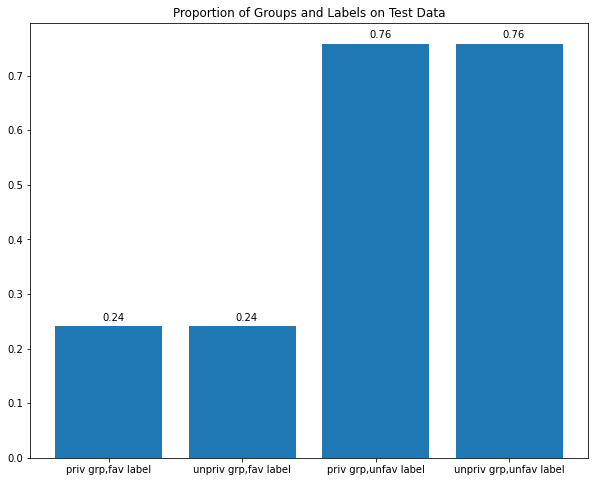

In [97]:
plot_prop_prtced_grp_lab(dset_raw_tst, "Proportion of Groups and Labels on Test Data")

In [36]:
dset_raw_tst_metrics = BinaryLabelDatasetMetric(dset_raw_tst,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)
print("Statistical Parity Difference:",dset_raw_tst_metrics.statistical_parity_difference())
print("Disparate Impact:",dset_raw_tst_metrics.disparate_impact())
print("Consistency:",dset_raw_tst_metrics.consistency()[0])

Statistical Parity Difference: -0.1867972998771832
Disparate Impact: 0.3835940007074953
Consistency: 0.7237971746400178


##### FITTING MODEL

Now, we fit a Logistic Regression Model

In [37]:
scaler = StandardScaler()
dset_trn = scaler.fit_transform(dset_raw_trn.features)
y_trn = dset_raw_trn.labels.ravel()

In [38]:
lmod= LogisticRegression(penalty='l2')
lmod.fit(dset_trn, y_trn)

LogisticRegression()

In [39]:
dset_tst_pred = dset_raw_tst.copy(deepcopy=True)
dset_tst = scaler.transform(dset_tst_pred.features)
dset_tst_pred.labels = lmod.predict(dset_tst)

In [71]:
dset_tst_prob = lmod.predict_proba(dset_tst)[:,1]

#### FAIRNESS OF MODEL

Taking a look at the fairness metris for the model's predictions on the test data, we get:

In [40]:
dset_tst_pred_metrics = BinaryLabelDatasetMetric(dset_tst_pred,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)
print("Statistical Parity Difference:",dset_tst_pred_metrics.statistical_parity_difference())
print("Disparate Impact:",dset_tst_pred_metrics.disparate_impact())
print("Consistency:",dset_tst_pred_metrics.consistency())

Statistical Parity Difference: -0.21217055052406636
Disparate Impact: 0.0
Consistency: 0.9998498600969085


We see training without any fairness intervention made the fairness issue with the dataset even worse. Except for individual fairness the fairness between classes of protected group is poor. Taking a look at the proportion of unprivileged group individuals who were given the favorable label by the model and privileged group proportion for the same, we see the model exhibits fairness problem severely.It classified no protected privileged group individual to favorable label and classified all unprivileged group individual to unfavorable label.

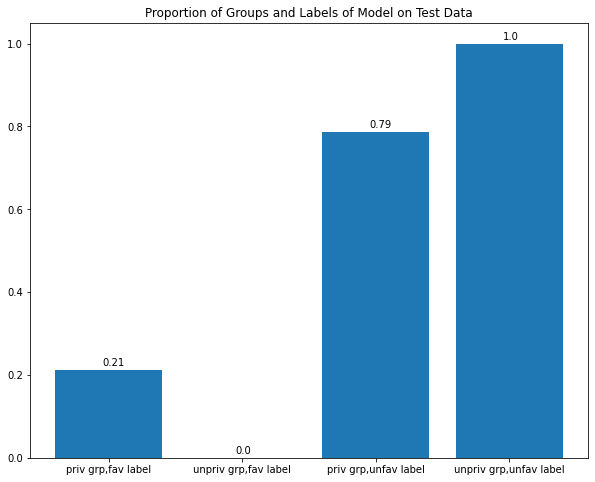

In [96]:
plot_prop_prtced_grp_lab(dset_tst_pred, "Proportion of Groups and Labels of Model on Test Data")

We will now evaluate the fairness of our model using several of the definitions for model fairness we saw [before](Fair-Classifier.ipynb).

In [72]:
mod_metrics = ClassificationMetric(dset_raw_tst, dset_tst_pred,
                                            unprivileged_groups=unpriv_group,
                                            privileged_groups=priv_group)
print("Accuracy:", mod_metrics.accuracy())
print("Predictive Parity Difference:", mod_metrics.positive_predictive_value(False)-mod_metrics.positive_predictive_value(True))
print("FNR Difference:", mod_metrics.false_negative_rate_difference())
print("Accuracy Difference:", mod_metrics.error_rate_difference())
print("Average Positive Class Difference:", np.mean(dset_tst_prob[(dset_raw_tst.labels.ravel() == 1.)&(dset_raw_tst.features[:,1].ravel() == 0.)])
                                        - np.mean(dset_tst_prob[(dset_raw_tst.labels.ravel() == 1.)&(dset_raw_tst.features[:,1].ravel() == 1.)]))
print("Average Negative Class Difference:", np.mean(dset_tst_prob[(dset_raw_tst.labels.ravel() == 0.)&(dset_raw_tst.features[:,1].ravel() == 0.)])
                                        - np.mean(dset_tst_prob[(dset_raw_tst.labels.ravel() == 0.)&(dset_raw_tst.features[:,1].ravel() == 1.)]))

Accuracy: 0.8044086535180509
Predictive Parity Difference: -0.6613908872901678
FNR Difference: 0.4630624580255205
Accuracy Difference: -0.1183125130653383
Average Positive Class Difference: -0.25324331468908357
Average Negative Class Difference: -0.13724064726347057


We see above that:
- Even though the model accuracy is good, it severely shows fairness issue as none of the difference values are close to 0. 
- Again, the same trend is seen that the unprivileged group gets the unfavorable label much more than the privileged group.
- A high value of FNR difference indicates the model wrongly labels unprivileged group individuals to unfavorable label.
- On an average our model predicts favorable outcome 25% more for privileged group compared to that of unprivileged group, where the individuals of both groups actually have a favorable outcome.
- On an average our model predicts favorable outcome 13.7% more for privileged group compared to that of unprivileged group, where the individuals of both groups actually have a unfavorable outcome.